Rodrigo García Salado
# Proceso EDA
---
1. Cargar los datos como un Pandas dataframe

2. LLevar a cabo un proceso EDA (Exploratory Data Analysis) para entender/comprender sus datos. Y esto significa:
  - Cuántas instancias y atributos hay
  - Qué tipo de atributos hay (numéricos o categóricos). Esto se hace para comprobar si hay características categóricas que deban ser codificadas (como dummies / one-hot-encoding)
  - Qué atributos tienen valores faltantes, y cuántos
  - Si se trata de un problema de clasificación o de regresión (variable de salida es una clase o un valor continuo), y en caso de clasificación, si la clase está desequilibrada.

3. Codificar el Pandas dataframe como una matriz numpy (transformar los valores categóricos y los valores faltantes)

4. Diseñar modelos de aprendizaje automático con scikit-learn

In [111]:
#imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pickle

He creado un entorno virtual y un archivo requirements.txt ya que me daba problemas al hacer ciertos imports

In [112]:
# Cargamos el archivo
data_df = pd.read_csv("attrition_25/attrition_availabledata_06.csv") 

Podemos comprobar el valos de las primeras instancias del dataframe

In [113]:
data_df.head()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,...,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,5.896431,5,3,3,2.0,4.0,3.0,33,Travel_Rarely,Research & Development,...,Y,13,8,0,6.0,3,5,1,4,No
1,6.114877,19,3,3,3.0,3.0,3.0,20,Travel_Rarely,Research & Development,...,Y,13,8,1,2.0,2,2,2,2,No
2,6.396730,11,3,3,1.0,4.0,4.0,46,Travel_Rarely,Research & Development,...,Y,11,8,1,28.0,2,7,4,3,Yes
3,5.722452,22,4,3,1.0,1.0,4.0,40,Travel_Rarely,Sales,...,Y,13,8,1,9.0,2,8,7,1,No
4,5.663001,21,3,3,4.0,4.0,3.0,38,Travel_Frequently,Research & Development,...,Y,17,8,3,10.0,2,10,9,9,No


El dataset es demasiado grande, por eso no podemos visualizarlo al completo

Ahora observamos cuantos y qué tipo de datos vamos a estar tratando


In [114]:
print('The shape of the data table is:')
print('===============================')
print(data_df.shape)
print()

print('The types of the attributes are:')
print('================================')
data_df.info()

print()

print('How many missing values per attribute:')
print('======================================')
print(data_df.isnull().sum())

print()

print('Fraction of missing values per attribute:')
print('======================================')
print(data_df.isnull().mean())


The shape of the data table is:
(2940, 31)

The types of the attributes are:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      2940 non-null   float64
 1   absences                 2940 non-null   int64  
 2   JobInvolvement           2940 non-null   int64  
 3   PerformanceRating        2940 non-null   int64  
 4   EnvironmentSatisfaction  2921 non-null   float64
 5   JobSatisfaction          2928 non-null   float64
 6   WorkLifeBalance          2913 non-null   float64
 7   Age                      2940 non-null   int64  
 8   BusinessTravel           2940 non-null   object 
 9   Department               2940 non-null   object 
 10  DistanceFromHome         2940 non-null   int64  
 11  Education                2940 non-null   int64  
 12  EducationField           2940 non-null   object 
 13  E

Gracias a este análisis sabemos que tendremos:

+ 2940 muestras (trabajadores)
+ 31 datos de cada una de ellas
    - Datos existentes de 3 tipos (object, int y float64)
    - Algunos datos faltan de ciertos trabajadores, pero comparándolo con el total no faltan demasiados
    - existen 8 variables de tipo object o categóricas que tendremos que convertir
+ Nuestra variable objetivo (attrition) es de tipo categórica, por lo que estamos ante un problema de clasificación


Puesto que nos encontramos ante un problema de clasificación debemos analizar si nuestra variable Attrition está equilibrada:

In [115]:
# Comprobar cuántas veces aparece cada clase en la columna 'Attrition'
print(data_df['Attrition'].value_counts())

# Comprobar la proporción de cada clase
print(data_df['Attrition'].value_counts(normalize=True))

Attrition
No     2466
Yes     474
Name: count, dtype: int64
Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64


Podemos observar que la variable objetivo está muy desvalanceada, por lo que más ademlante debemos tenerlo en cuenta para nuestro arbol


# Preprocesado
---


Primero debemos comprobar que variables son innecesarias y, por tanto, se pueden eliminar, como aquellas constantes.


Tambien analizaremos la cardinalidad de nuestras variables para ver cuales poseen una demasiado alta

In [116]:
# Identificar columnas constantes
constant_columns = [col for col in data_df.columns if data_df[col].nunique() == 1]

# Eliminar las columnas constantes del dataframe
processed_df = data_df.drop(columns=constant_columns)

# Mostrar las columnas eliminadas
print(f"Columnas eliminadas (constantes): {constant_columns}")

Columnas eliminadas (constantes): ['EmployeeCount', 'Over18', 'StandardHours']


In [117]:
# Paso 1: Identificar variables categóricas
categorical_columns = processed_df.select_dtypes(include=['object']).columns

# Paso 2: Contar las categorías únicas por variable
cardinality = processed_df[categorical_columns].nunique()

print("Cardinalidad de las variables categóricas:")
print(cardinality)

Cardinalidad de las variables categóricas:
BusinessTravel    3
Department        3
EducationField    6
Gender            2
JobRole           9
MaritalStatus     3
Attrition         2
dtype: int64


Éstos datos nos indican que no tenemos ninguna variable con demasiada cardinalidad.

variable con más cardinalidad: "JobRole" con 9

debemos tener en cuenta las diferentes opciones de escalado e imputación para la creación de los pipelines y obtener así la mejor de todas

In [118]:
numerical_columns = processed_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = processed_df.select_dtypes(include=['object']).columns.drop('Attrition')


# Opciones de escalado e imputación
scalers = {
    "standard": StandardScaler(),
    "minmax": MinMaxScaler(),
    "robust": RobustScaler()
}

imputers = {
    "mean": SimpleImputer(strategy="mean"),
    "median": SimpleImputer(strategy="median")
}





Generamos nuestra funcion para crear distintos pipelines

Como el dataset se encuentra desbalanceado debemos incluir `class_weight='balanced' en el clasifier

también transformaremos nuestras variables categóricas con OneHotEncoder ya que éstas variables no tienen demasiada cardinalidad, por tanto no estaremos añadiendo demasiadas columnas.

In [119]:
# Definir pipeline base
def create_pipeline(scaler, imputer):
    numerical_transformer = Pipeline(steps=[
        ('imputer', imputer),
        ('scaler', scaler)
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ]
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(class_weight='balanced'))
    ])

    return pipeline



Ahora comprobaremos la correlación de las variables con respecto a nuestra variable objetivo:

/tmp/ipykernel_4284/762779316.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_correlation.index, y=top_correlation.values, palette="coolwarm")


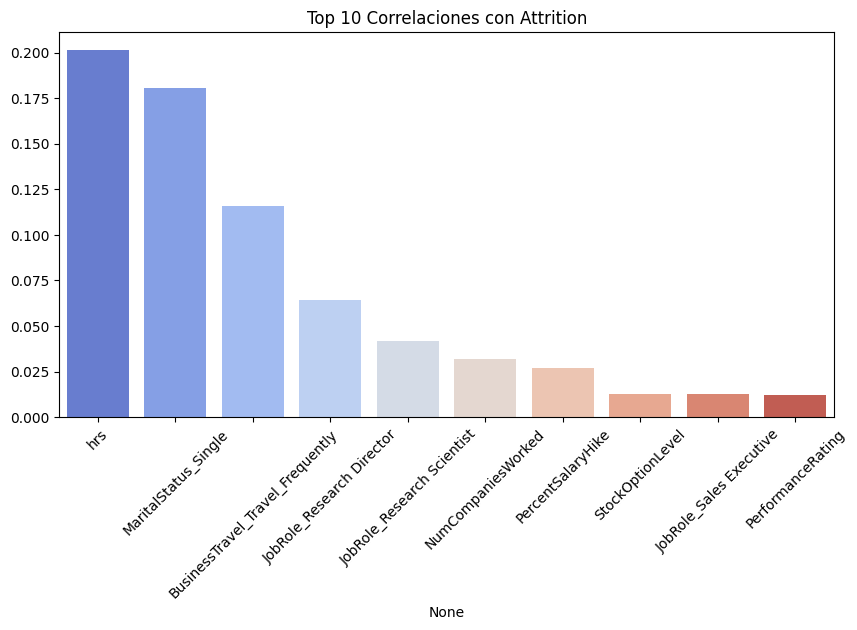

In [120]:
# Mapea directamente la columna 'Attrition' a valores binarios
processed_df['Attrition'] = processed_df['Attrition'].map({'Yes': 1, 'No': 0})

# Usar OneHotEncoder para convertir variables categóricas en variables numéricas para calcular la correlación
# No necesitio modificar mi processed_df porque mis pipes ya me modifican los valores categoricos con OneHotEncoder
Modificada_df = pd.get_dummies(processed_df, drop_first=True)

# Calcular la correlación de todas las variables con 'Attrition'
correlation_with_attrition = Modificada_df.corr()['Attrition'].sort_values(ascending=False)

# Seleccionar las 10 variables con la mayor correlación para mostrarlas
top_n = 10
top_correlation = correlation_with_attrition[1:top_n+1]  # Excluimos 'Attrition' que siempre tendrá correlación 1

# Mostrar el gráfico de correlación
plt.figure(figsize=(10, 5))
sns.barplot(x=top_correlation.index, y=top_correlation.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title(f"Top {top_n} Correlaciones con Attrition")
plt.show()


Esto indica que las horas de trabajo están fuertemente relacionadas al igual que si nuestro trabajador está casado o no.



Codificamos la salida separando los datos en train/test (Holdout)

In [121]:
X = processed_df.drop(columns=['Attrition'])  # Elimina la columna 'Attrition'
y = processed_df['Attrition']  # Definir la variable objetivo

# Seleccionados train/test en modo stratify, ya que el dataset se encuentra desbalanceado
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=1/3, random_state=42)
# hago siempre el mismo random_state para que siemrpe me de los mismos resultados

print(X_train)


           hrs  absences  JobInvolvement  PerformanceRating  \
2607  6.727603        14               4                  3   
1743  5.931371         7               3                  3   
1073  7.908533        20               2                  3   
2892  9.996780        17               2                  3   
2427  6.050374        11               3                  3   
...        ...       ...             ...                ...   
1106  9.933382         5               2                  3   
207   6.583981        21               3                  3   
2806  7.853409         5               3                  4   
303   6.868564        19               2                  4   
2120  9.670089        15               3                  3   

      EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance  Age  \
2607                      2.0              2.0              3.0   39   
1743                      4.0              3.0              3.0   37   
1073                      4

## Hiperparámetros y evaluacion de modelos

Llevamos a cabo la optimizacion de hiperparámetros utilizando KNN



In [122]:
# Definir los hiperparámetros para buscar
param_grid = {
        'preprocessor__num__imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='median')],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7, 10, 15],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    }



grid_search = GridSearchCV(
    create_pipeline(MinMaxScaler(), SimpleImputer(strategy="mean")),  # Necesita un Pipeline base
    param_grid, # El pipeline base anterior lo reemplaza por todas las opciones aquí
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

# Medir tiempo de entrenamiento con HPO
start_time = time.time()
grid_search.fit(X_train, y_train)   # Entrenar el modelo con GridSearchCV
end_time = time.time()

GridTime = end_time - start_time


# Mostrar los mejores parámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)


# Acceder al mejor modelo entrenado
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

ElMejorModeloKNN = best_model #Esto lo guardo para más adelante, ya que veremos que nos da la mejor de las predicciones


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Mejores hiperparámetros: {'classifier': KNeighborsClassifier(), 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance', 'preprocessor__num__imputer': SimpleImputer(), 'preprocessor__num__scaler': RobustScaler()}


Los mejores hiperparámetros que ha elegido GridSearchCV son:

-   Criterio de división del árbol -> 'gini'
-   Profundidad máxima del árbol -> None (es decir, sin límite de profundidad)
-   Mínimo de muestras por hoja -> 2
-   Método de imputación -> SimpleImputer() (por defecto usa strategy='mean', es decir, reemplazar valores faltantes con la media)
-   Método de escalado -> StandardScaler() (escalado estándar: media 0, desviación estándar 1)





Finalmente sacamos nuestra validación cruzada

In [123]:
# Realizar validación cruzada con 5 folds en los datos de entrenamiento
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring="balanced_accuracy", n_jobs=-1)

# Mostrar los resultados
print("Media de validación cruzada con hiperparámetros KNN:", cv_scores.mean())

Media de validación cruzada con hiperparámetros KNN: 0.8135746153244208


Ahora se evaluará con los hiperparámetros por omisión

In [124]:
# Crear el pipeline con los valores predeterminados
default_pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer()), 
            ('scaler', StandardScaler())  
        ]), numerical_columns),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_columns)
    ])),
    ('classifier', KNeighborsClassifier()) 
])


# Medir tiempo de entrenamiento con HPO
start_time = time.time()
default_pipeline.fit(X_train, y_train)  # Entrenar el modelo
end_time = time.time()

defaultTime = end_time - start_time

# Predecir con el modelo por defecto
y_pred_default = default_pipeline.predict(X_test)

# Realizar validación cruzada con 5 folds en los datos de entrenamiento
cv_scores = cross_val_score(default_pipeline, X_train, y_train, cv=5, scoring="balanced_accuracy", n_jobs=-1)

# Mostrar los resultados
print("Media de validación cruzada sin hiperparámetros KNN:", cv_scores.mean())


Media de validación cruzada sin hiperparámetros KNN: 0.5889364842546602


Calculamos las métricas de ambos métodos y calculamos TPR y TNR partiendo de la matriz de confusion

In [125]:
balanceado = balanced_accuracy_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
matrizConfusion = confusion_matrix(y_test, y_pred)

# Evaluar el modelo por omisión
default_acc = accuracy_score(y_test, y_pred_default)
default_balanced_acc = balanced_accuracy_score(y_test, y_pred_default)



print("BalancedAcc:", balanceado)
print(f"\nBalanced Accuracy con hiperparámetros por omisión: {default_balanced_acc}")
print("--------------------------------------")
print("Acc:", acc)
print(f"\nAcc con hiperparámetros por omisión: {default_acc}")
print("--------------------------------------")
print("MatrizConf:", matrizConfusion)
print("--------------------------------------")
print("Tiempo de entrenamiento con HPO:", GridTime)
print("Tiempo de entrenamiento con valores por omisión:", defaultTime)
print("--------------------------------------\n\n")

TPR = matrizConfusion[1, 1] / (matrizConfusion[1, 0] + matrizConfusion[1, 1])  
TNR = matrizConfusion[0, 0] / (matrizConfusion[0, 0] + matrizConfusion[0, 1])

print("True Positive Rate sin hiperparámetros por omisión: ", TPR)
print("True Negative Rate sin hiperparámetros por omisión: ", TNR)



BalancedAcc: 0.8905879454248669

Balanced Accuracy con hiperparámetros por omisión: 0.6010271335735625
--------------------------------------
Acc: 0.9408163265306122

Acc con hiperparámetros por omisión: 0.8581632653061224
--------------------------------------
MatrizConf: [[793  29]
 [ 29 129]]
--------------------------------------
Tiempo de entrenamiento con HPO: 20.88341212272644
Tiempo de entrenamiento con valores por omisión: 0.029410123825073242
--------------------------------------


True Positive Rate sin hiperparámetros por omisión:  0.8164556962025317
True Negative Rate sin hiperparámetros por omisión:  0.9647201946472019


---
Ahora haremos lo mismo con DTC

Creamos el grid search

In [126]:

# HPO: Búsqueda de hiperparámetros óptimos
param_grid2 = {
        'classifier': [DecisionTreeClassifier(random_state=42, class_weight='balanced')],
        'preprocessor__num__imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='median')],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'classifier__max_depth': [3, 5, 10, 15, 20, 25, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__criterion': ['gini', 'entropy']
    }

grid_search2 = GridSearchCV(
    create_pipeline(MinMaxScaler(), SimpleImputer(strategy="mean")), 
    param_grid2,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

Entrenamiento con hiperparámetros

In [127]:
start_time = time.time()
grid_search2.fit(X_train, y_train)
tiempo = time.time() - start_time

best_DTC = grid_search2.best_estimator_
y_pred_best = best_DTC.predict(X_test)
DTC_Bal_acc = balanced_accuracy_score(y_test, y_pred_best)
DTC_acc = accuracy_score(y_test, y_pred_best)

# Realizar validación cruzada con 5 folds en los datos de entrenamiento
cv_scores = cross_val_score(best_DTC, X_train, y_train, cv=5, scoring="balanced_accuracy", n_jobs=-1)

# Mostrar los resultados
print("Media de validación cruzada con hiperparámetros DTC:", cv_scores.mean())


print(f"Default Decision Tree BalancedAcc: {DTC_Bal_acc:.4f}, con un tiempo de: {tiempo:.4f} s")
print(f"Mejores parámetros: {grid_search2.best_params_}")


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Media de validación cruzada con hiperparámetros DTC: 0.7721239811657234
Default Decision Tree BalancedAcc: 0.8210, con un tiempo de: 32.1462 s
Mejores parámetros: {'classifier': DecisionTreeClassifier(class_weight='balanced', random_state=42), 'classifier__criterion': 'entropy', 'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'preprocessor__num__imputer': SimpleImputer(strategy='median'), 'preprocessor__num__scaler': StandardScaler()}


Hiperparámetros por omisión del DTC

In [128]:
# Crear el pipeline con los valores predeterminados
default_pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer()),  
            ('scaler', StandardScaler())  
        ]), numerical_columns),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_columns)
    ])),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

start_time = time.time()
default_pipeline.fit(X_train, y_train)  # Entrenar el modelo
end_time = time.time()

defaultTime = end_time - start_time

# Predecir con el modelo por defecto
y_pred_default = default_pipeline.predict(X_test)

# Realizar validación cruzada con 5 folds en los datos de entrenamiento
cv_scores = cross_val_score(default_pipeline, X_train, y_train, cv=5, scoring="balanced_accuracy", n_jobs=-1)

# Mostrar los resultados
print("Media de validación cruzada sin hiperparámetros DTC:", cv_scores.mean())

Media de validación cruzada sin hiperparámetros DTC: 0.7391175860371826


Calculamos las métricas de ambos métodos y calculamos TPR y TNR partiendo de la matriz de confusion

In [129]:

matrizConfusion = confusion_matrix(y_test, y_pred_best)

# Evaluar el modelo por omisión
default_acc = accuracy_score(y_test, y_pred_default)
default_balanced_acc = balanced_accuracy_score(y_test, y_pred_default)



print("BalancedAcc:", DTC_Bal_acc)
print(f"\nBalanced Accuracy con hiperparámetros por omisión: {default_balanced_acc}")
print("--------------------------------------")
print("Acc:", DTC_acc)
print(f"\nAcc con hiperparámetros por omisión: {default_acc}")
print("--------------------------------------")
print("MatrizConf:", matrizConfusion)
print("--------------------------------------")
print("Tiempo de entrenamiento con HPO:", tiempo)
print("Tiempo de entrenamiento con valores por omisión:", defaultTime)
print("--------------------------------------\n\n")

TPR = matrizConfusion[1, 1] / (matrizConfusion[1, 0] + matrizConfusion[1, 1])  
TNR = matrizConfusion[0, 0] / (matrizConfusion[0, 0] + matrizConfusion[0, 1])

print("True Positive Rate: ", TPR)
print("True Negative Rate: ", TNR)


BalancedAcc: 0.8209753919122855

Balanced Accuracy con hiperparámetros por omisión: 0.8217068588499801
--------------------------------------
Acc: 0.8969387755102041

Acc con hiperparámetros por omisión: 0.8938775510204081
--------------------------------------
MatrizConf: [[767  55]
 [ 46 112]]
--------------------------------------
Tiempo de entrenamiento con HPO: 32.14619994163513
Tiempo de entrenamiento con valores por omisión: 0.08452606201171875
--------------------------------------


True Positive Rate:  0.7088607594936709
True Negative Rate:  0.9330900243309003


## ANÁLISIS

Segun los datos obtenidos nos fijaremos más en el balanced acuracy ya que nuestra variable objetivo está desbalanceada:

1. Cuando utilizamos GridSearch cpon el KNN obtenemos mejores parámetros, con un acierto mayor a los valores por omisión (0.89 frente a 0.81).
Lo mismo ocurre con el DTC (0.81 frente a 0.6)

2. El coste computacional es mucho mayor en el GridSearch ya que comprueba todas las combinaciones posibles, de esa manera obtiene un porcentage de acierto mayor.

3. El modelo optimizado es mucho mejor que un modelo trivial como DummyClassifier que tendría un BalancedAcc mucho menor ya que asigna valores al azar sin tener en cuenta otros parámetros.

4. En definitiva hay una mejora de aproximadamente el 7% entre ambos métodos del KNN, que podemos considerar bastante significativa y, por tanto, concluiremos que nuestro método por ajuste de hiperparámetros (el GridSearch) es mejor al método de valores por omisión pero a un coste computacional mucho mayor. 

5. EL método KNN es considerablemente más preciso que el Decision tree clasifier ya que el balanced acuracy de ambos es del 0.81 en el DTC y del 0.89 en el KNN.

6. Mediante el método KNN a la hora de buscar los mejores hiperparámetros se ha dedido que el numero de vecinos será 3, es decir el más pequeño dado que choca con el DTC que necesitará una profundidad máxima de 15, es decir la más grande dada y un minimo de muestras de 5.

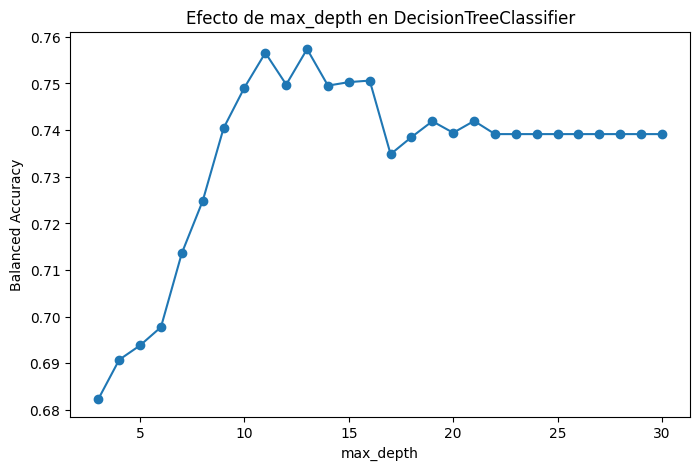

In [130]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Definir el pipeline para preprocesamiento de datos
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

# Lista de valores para max_depth
max_depth_values = list(range(3, 31))
dtc_scores = []

# Evaluar diferentes valores de max_depth
for depth in max_depth_values:
    dtc_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=42))
    ])
    
    scores = cross_val_score(dtc_pipeline, X_train, y_train, cv=5, scoring='balanced_accuracy')
    dtc_scores.append(np.mean(scores))

# Graficar los resultados
plt.figure(figsize=(8, 5))
plt.plot(max_depth_values, dtc_scores, marker='o', linestyle='-')
plt.xlabel("max_depth")
plt.ylabel("Balanced Accuracy")
plt.title("Efecto de max_depth en DecisionTreeClassifier")
plt.show()


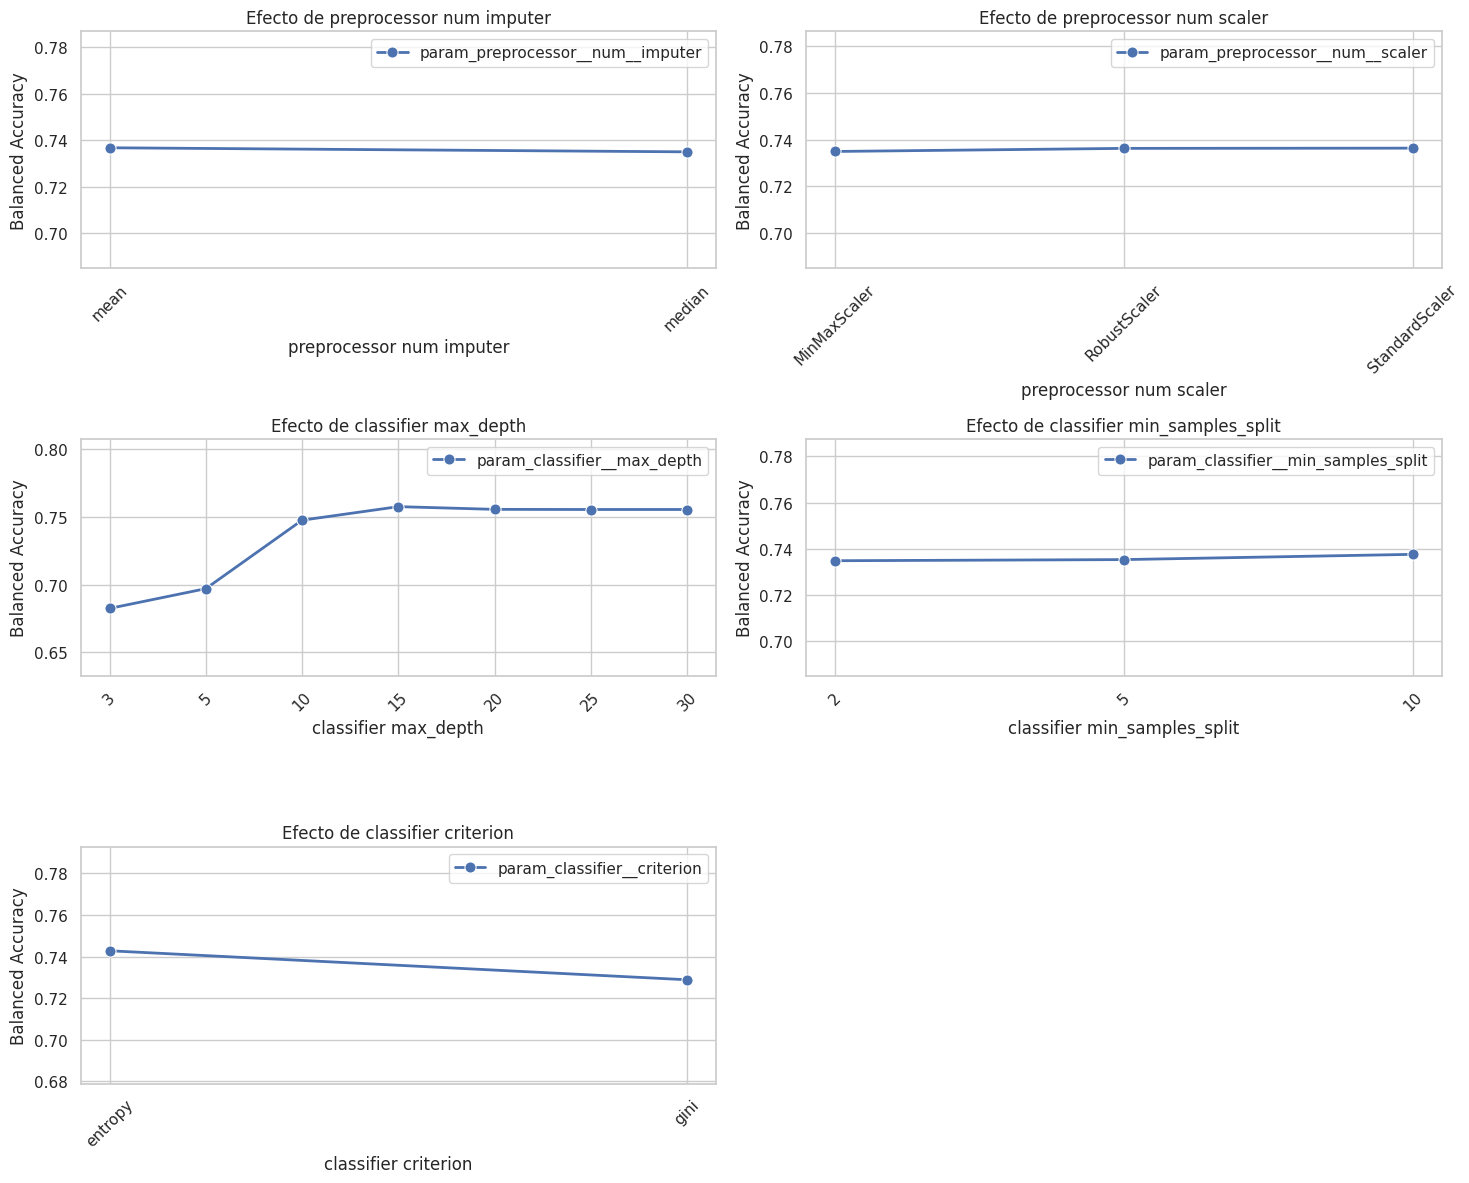

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener resultados de GridSearchCV
cv_results = pd.DataFrame(grid_search2.cv_results_)

# Reemplazar las instancias de los imputadores y escaladores por su nombre
cv_results['param_preprocessor__num__imputer'] = cv_results['param_preprocessor__num__imputer'].apply(lambda x: x.strategy)
cv_results['param_preprocessor__num__scaler'] = cv_results['param_preprocessor__num__scaler'].apply(lambda x: x.__class__.__name__)

# Establecer estilo de gráficos
sns.set(style="whitegrid")

# Lista de hiperparámetros a graficar
hyperparams = [
    "param_preprocessor__num__imputer",
    "param_preprocessor__num__scaler",
    "param_classifier__max_depth",
    "param_classifier__min_samples_split",
    "param_classifier__criterion"
]

# Graficar cada hiperparámetro
plt.figure(figsize=(15, 12))

for i, param in enumerate(hyperparams, 1):
    plt.subplot(3, 2, i)

    # Promediar sobre los demás hiperparámetros
    mean_scores = cv_results.groupby(param)["mean_test_score"].mean()

    # Calcular límites dinámicos para el eje y
    y_min, y_max = mean_scores.min() - 0.05, mean_scores.max() + 0.05

    # Crear el gráfico con líneas y puntos
    sns.lineplot(x=mean_scores.index.astype(str), y=mean_scores.values, marker='o', linewidth=2, markersize=8, linestyle='-', label=param)

    # Establecer los límites del eje y
    plt.ylim(y_min, y_max)

    # Rotar las etiquetas del eje x
    plt.xticks(rotation=45)

    plt.xlabel(param.replace("param_", "").replace("__", " "))
    plt.ylabel("Balanced Accuracy")
    plt.title(f"Efecto de {param.replace('param_', '').replace('__', ' ')}")

plt.tight_layout()
plt.show()


## Modelos Lineales

debemos crear un nuevo pipeline ya que nuestro clasifier está fijo en nuestra función anterior y nos da problemas un solver frente a otro si no tenemos restricciones en la regresión o si tenemos restriccion de tipo L1.

In [131]:
def create_pipeline_2(scaler, imputer, classifier):
    numerical_transformer = Pipeline(steps=[
        ('imputer', imputer),
        ('scaler', scaler)
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ]
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    return pipeline

Sin regulación L1:

In [132]:
start_time = time.time()    # comenzamos el tiempo

SinL1 = create_pipeline_2(StandardScaler(), SimpleImputer(strategy='mean'), LogisticRegression(penalty=None, solver='lbfgs')) 
# "solver='lbfgs'" es un algoritmo de optimización que es compatible con la configuración penalty=None
SinL1.fit(X_train, y_train)    # Entrenamos

end_time = time.time()  # Paramos el timepo

# Calculamos métricas

y_pred_lr = SinL1.predict(X_test)
lr_acc = accuracy_score(y_test, y_pred_lr)
lr_bal_acc = balanced_accuracy_score(y_test, y_pred_lr)

print("Regresión Logística (sin regularización)")
print("Accuracy:", lr_acc)
print("Balanced Accuracy:", lr_bal_acc)
print("Tiempo de entrenamiento:", end_time - start_time)

Regresión Logística (sin regularización)
Accuracy: 0.8540816326530613
Balanced Accuracy: 0.6241568881086575
Tiempo de entrenamiento: 0.17612147331237793


Con regulación L1:

In [133]:
start_time = time.time()

ConL1 = create_pipeline_2(StandardScaler(), SimpleImputer(strategy='mean'), LogisticRegression(penalty='l1', solver='liblinear')) 
ConL1.fit(X_train, y_train) # Entrenamos

end_time = time.time()

# Calculmos métricas

y_pred_ConL1 = ConL1.predict(X_test)
ConL1_acc = accuracy_score(y_test, y_pred_ConL1)
COnL1_bal_acc = balanced_accuracy_score(y_test, y_pred_ConL1)

print("Regresión Logística (con L1)")
print("Accuracy:", ConL1_acc)
print("Balanced Accuracy:", COnL1_bal_acc)
print("Tiempo de entrenamiento:", end_time - start_time)

Regresión Logística (con L1)
Accuracy: 0.8561224489795919
Balanced Accuracy: 0.6228171486648804
Tiempo de entrenamiento: 0.06388354301452637


SVM con hiperparámetros por omisión:

In [134]:
start_time = time.time()
svc = create_pipeline_2(StandardScaler(), SimpleImputer(strategy='mean'), SVC())
svc.fit(X_train, y_train)

end_time = time.time()

y_pred_svm = svc.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
svm_bal_acc = balanced_accuracy_score(y_test, y_pred_svm)

print("SVM (parámetros por defecto)")
print("Accuracy:", svm_acc)
print("Balanced Accuracy:", svm_bal_acc)
print("Tiempo de entrenamiento:", end_time - start_time)


SVM (parámetros por defecto)
Accuracy: 0.8785714285714286
Balanced Accuracy: 0.6361991437987002
Tiempo de entrenamiento: 0.1825108528137207


---
Optimizacion de hiperparámetros con gridsearch:

Primero sin penalizacion L1:

In [135]:
param_grid_sin_penalizacion = {
    'preprocessor__num__imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='median')],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'classifier': [LogisticRegression(max_iter=1000)],
    'classifier__penalty': [None],
    'classifier__solver': ['lbfgs'],

}

grid_search_sin_penalizacion = GridSearchCV(
    create_pipeline_2(StandardScaler(), SimpleImputer(strategy='mean'), LogisticRegression(max_iter=1000)), 
    param_grid_sin_penalizacion,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search_sin_penalizacion.fit(X_train, y_train)
end_time = time.time()

y_pred_lr = grid_search_sin_penalizacion.predict(X_test)

matrizConfusion = confusion_matrix(y_test, y_pred_lr)

TPR = matrizConfusion[1, 1] / (matrizConfusion[1, 0] + matrizConfusion[1, 1])  
TNR = matrizConfusion[0, 0] / (matrizConfusion[0, 0] + matrizConfusion[0, 1])

print("True Positive Rate: ", TPR)
print("True Negative Rate: ", TNR)

print(f"Mejores hiperparámetros (Sin penalización): {grid_search_sin_penalizacion.best_params_}")
print(f"Tiempo de entrenamiento (Sin penalización): {end_time - start_time:.4f} segundos")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
True Positive Rate:  0.2848101265822785
True Negative Rate:  0.9635036496350365
Mejores hiperparámetros (Sin penalización): {'classifier': LogisticRegression(max_iter=1000), 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'preprocessor__num__imputer': SimpleImputer(strategy='median'), 'preprocessor__num__scaler': RobustScaler()}
Tiempo de entrenamiento (Sin penalización): 0.8793 segundos


Con penalizacion L1:

In [136]:
param_grid_con_penalizacion_L1 = {
    'preprocessor__num__imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='median')],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'classifier': [LogisticRegression(max_iter=1000)],
    'classifier__penalty': ['l1'], 
    'classifier__solver': ['liblinear'], 
    'classifier__C': [0.1, 1, 10],
}
grid_search_con_penalizacion_L1 = GridSearchCV(
    create_pipeline_2(StandardScaler(), SimpleImputer(strategy='mean'), LogisticRegression(max_iter=1000)),
    param_grid_con_penalizacion_L1,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search_con_penalizacion_L1.fit(X_train, y_train)
end_time = time.time()

y_pred_lr = grid_search_con_penalizacion_L1.predict(X_test)

matrizConfusion = confusion_matrix(y_test, y_pred_lr)

TPR = matrizConfusion[1, 1] / (matrizConfusion[1, 0] + matrizConfusion[1, 1])  
TNR = matrizConfusion[0, 0] / (matrizConfusion[0, 0] + matrizConfusion[0, 1])

print("True Positive Rate: ", TPR)
print("True Negative Rate: ", TNR)

print(f"Mejores hiperparámetros (Penalización L1): {grid_search_con_penalizacion_L1.best_params_}")
print(f"Tiempo de entrenamiento (Penalización L1): {end_time - start_time:.4f} segundos")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
True Positive Rate:  0.2848101265822785
True Negative Rate:  0.9647201946472019
Mejores hiperparámetros (Penalización L1): {'classifier': LogisticRegression(max_iter=1000), 'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'preprocessor__num__imputer': SimpleImputer(), 'preprocessor__num__scaler': StandardScaler()}
Tiempo de entrenamiento (Penalización L1): 4.4057 segundos


Para el SVC será algo distinto, ya que el paramgrid cambia (no se trata de regresión linear esta vez)

Para ésta funcion del param_grid_svc he utilizado IA generativa ChatGPT, obteniendo más opciones como el kernel, gamma, o function shape

In [137]:
param_grid_svc = {
    'preprocessor__num__imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='median')],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'classifier': [SVC()],
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],  # Diferentes tipos de kernel
    'classifier__gamma': ['scale', 'auto'],  # Gamma, afecta el ajuste del modelo (sólo si kernel = rbf o poly)
    'classifier__decision_function_shape': ['ovo', 'ovr'],  # Forma de la función de decisión
}

grid_search_svc = GridSearchCV(
    create_pipeline_2(StandardScaler(), SimpleImputer(strategy="mean"), SVC()), 
    param_grid_svc,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search_svc.fit(X_train, y_train)
end_time = time.time()

y_pred_lr = grid_search_svc.predict(X_test)

matrizConfusion = confusion_matrix(y_test, y_pred_lr)

TPR = matrizConfusion[1, 1] / (matrizConfusion[1, 0] + matrizConfusion[1, 1])  
TNR = matrizConfusion[0, 0] / (matrizConfusion[0, 0] + matrizConfusion[0, 1])

print("True Positive Rate: ", TPR)
print("True Negative Rate: ", TNR)

print("Mejores hiperparámetros (Con SVC):", grid_search_svc.best_params_)
print("Tiempo de búsqueda de hiperparámetros:", end_time - start_time)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
True Positive Rate:  0.7848101265822784
True Negative Rate:  0.9610705596107056
Mejores hiperparámetros (Con SVC): {'classifier': SVC(), 'classifier__C': 10, 'classifier__decision_function_shape': 'ovo', 'classifier__gamma': 'scale', 'classifier__kernel': 'poly', 'preprocessor__num__imputer': SimpleImputer(), 'preprocessor__num__scaler': MinMaxScaler()}
Tiempo de búsqueda de hiperparámetros: 113.22812032699585


Evaluamos los mejores hiperparámetros:

In [138]:
# Para un modelo como la regresión logística con L1 sin penalización
best_model_sin_L1 = grid_search_sin_penalizacion.best_estimator_
y_pred_lr_sin_L1 = best_model_sin_L1.predict(X_test)

# Para el modelo con L1
best_model_con_L1 = grid_search_con_penalizacion_L1.best_estimator_
y_pred_lr_con_L1 = best_model_con_L1.predict(X_test)

# Para el modelo SVM optimizado
best_model_svc = grid_search_svc.best_estimator_
y_pred_svm = best_model_svc.predict(X_test)

# Evaluamos todos los modelos
lr_acc_sin_L1 = accuracy_score(y_test, y_pred_lr_sin_L1)
lr_bal_acc_sin_L1 = balanced_accuracy_score(y_test, y_pred_lr_sin_L1)

lr_acc_con_L1 = accuracy_score(y_test, y_pred_lr_con_L1)
lr_bal_acc_con_L1 = balanced_accuracy_score(y_test, y_pred_lr_con_L1)

svm_acc = accuracy_score(y_test, y_pred_svm)
svm_bal_acc = balanced_accuracy_score(y_test, y_pred_svm)

print("Resultados para la regresión logística (sin L1):")
print("Accuracy:", lr_acc_sin_L1)
print("Balanced Accuracy:", lr_bal_acc_sin_L1)

print("\nResultados para la regresión logística (con L1):")
print("Accuracy:", lr_acc_con_L1)
print("Balanced Accuracy:", lr_bal_acc_con_L1)

print("\nSVM (con hiperparámetros optimizados):")
print("Accuracy:", svm_acc)
print("Balanced Accuracy:", svm_bal_acc)

Resultados para la regresión logística (sin L1):
Accuracy: 0.8540816326530613
Balanced Accuracy: 0.6241568881086575

Resultados para la regresión logística (con L1):
Accuracy: 0.8551020408163266
Balanced Accuracy: 0.6247651606147402

SVM (con hiperparámetros optimizados):
Accuracy: 0.9326530612244898
Balanced Accuracy: 0.872940343096492


### ANALISIS
1.  Podemos observar que por medio del modelo SVM obtenemos un balanced accuracy del 0.87, muy superior a los resultados por regresión logística que obtienen un 0.62

2.  Los modelos de regresión logística son muy similares entre aquel con restricción L1 y aquel sin ella, con una diferencia del 0.0006. Se vé más claramente la aportación de la restricción L1 en el TPR y el TNR de ambos, que poseen mas variación entre ellas.

3. Destacamos la baja precisión de los modelos de regresión lineal a raíz de los atributos, ya que como no son linealmente separables la regresión logística (tenga o no restriccion) no funciona bien.

Generamos nuestro PKL, que guardamos previamente

In [139]:
with open('modelo_final.pkl', 'wb') as file:
    pickle.dump(ElMejorModeloKNN, file)